# _In Silico_ Particle Simulator: Monte Carlo Simulations with _Faunus_

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import numpy as np
import os.path, os, sys, json
from IPython.display import HTML
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
workdir=%pwd
print(workdir)

/Users/giulio/particletracking/mc


## Model System

The model system is a cubic box of side length $L$ where $N$ particles are located on the xy-plane and translate in the x- and y-directions.

Particles interact via $\propto$ r$^{-12}$ and $\propto$ r$^{-3}$ pair-potentials. 
The $\propto$ r$^{-12}$ potential, modelling the exchange repulsions between finite-size particles, is given by

\begin{equation}
u_{rep}(r) = \epsilon \frac{\sigma^{12}}{r^{12}}
\end{equation}
where $\sigma$ is the particle's diameter, and $\epsilon$ is an energy parameter.

The $\propto$ r$^{-3}$ potential, modelling the magnetic dipole-dipole interaction, reads as

\begin{equation}
u_{d-d}(r) = \frac{C}{r^{3}}
\end{equation}

where C is a constant proportional to the squared magnitude of the particle's magnetic dipole moment (page 83 [Israelachvili](http://www.sciencedirect.com/science/book/9780123751829)).

In molecular simulations, the boundary effects related to the small size of the simulation box compared to bulk systems is often handled using periodic boundary conditions (PBC): any particle passing through one boundary of the simulation cell comes back into the cell through the opposite boundary (page 34 [Frenkel & Smit](http://www.sciencedirect.com/science/book/9780122673511)).

If we do not use PBC in our simulation, our system would be confined by hard walls corresponding to the repulsive magnetic bars at the sides of the 2D particle simulator.

## Running MC simulations

To simulate magnetic particles interacting on a plane we use a custom Metropolis Monte Carlo (MC) program built within the [Faunus framework](https://mlund.github.io/neofaunus/docs/). 

The following cells generate the input file to simulate the system with and without PBC.

The keyword `mcloop` determines the number of MC sweeps (_macro_ $\times$ _micro_).

`atomlist` indicates the type of atoms in the system. We are going to simulate magnetic particles (*MP*). The [trial moves](https://mlund.github.io/neofaunus/docs/moves/) for these particles are translations in the xy-plane and the length of the displacement is determined by the product of *dp* times a random unit vector.

Below the keyword `insertmolecules` we set the number of magnets in the system.

Below the keyword `energy` we set the nonbonded interactions. _sigma_ sets the particle diameter, _prefactor_ sets the constant for the $r^{-3}$-interaction (*C*) while lj-prefactor sets the energy parameter for the $r^{-12}$-interaction ($\epsilon$). In the case of simulations with hard walls, we add an additional term to the [Hamiltonian](https://mlund.github.io/neofaunus/docs/energy/) which confines the particles in $-L/2\leq x\leq L/2$ and $-L/2\leq y\leq L/2$. This term is a quadratic function of the distance from the boundary with spring constant $k$ that is applied to the particle when it is outside the boundaries.

Finally, below [`analysis`](https://mlund.github.io/neofaunus/docs/analysis/) we indicate the analysis that we want to perform during the simulation. Here, we specify that we want to save each configuration into a trajectory file and the final configuration into a `gro` file. We also want to print to file the energy of the system (total, nonbonded, or confinement) for each frame.

Trajectory files are saved in `xtc` format – notice that the default length unit in `Faunus` is Å while coordinates are saved in nm in `xtc` and `gro` files.

### Some Important Parameters

In [89]:
# particle diameter
sigma = 30.
# particle displacement
dp = 100
# number of particles
N = 40
# Side length of the box
L = 600.
# Prefactor C
C = 1.5e6
# lj-prefactor
epsilon = 10
# number of MC sweeps
micro = 1e4
# trajectory file name
trajname = 'traj_'+str(N)
# final configuration file name
confname = 'conf_'+str(N)
# energy file name
energyname = 'energy_'+str(N)

### Simulations with PBC

In [90]:
js = { 
"temperature": 298,
"mcloop": {"macro": 1, "micro": micro},
"geometry": {"length": L},
"energy": [ 
    { "nonbonded": { "default": [ 
        { "repulsionr3": {"prefactor": C, "lj-prefactor": epsilon, "sigma": sigma} } ] } } ],
"atomlist": [
    { "MP": {"dp": dp} } ],
"moleculelist": [
    { "magnets": {"atoms": ["MP"], "atomic": True, "insdir": [1,1,0]} } ],
"insertmolecules": [
    { "magnets": {"N": N} } ],
"moves": [
    { "transrot": {"molecule": "magnets", "dir": [1,1,0]} } ],
"analysis": [
    { "xtcfile": {"file": trajname+"_pbc.xtc", "nstep": 10} },
    {"savestate": {"file": confname+"_pbc.gro"} },
    {"systemenergy": {"file": energyname+"_pbc.dat", "nstep": 10} } ] } 
with open('pbc.json', 'w+') as f:
    f.write(json.dumps(js, indent=4))

!faunus -i pbc.json

[======================================================================] 100% 2.534s
relative drift = 1.78667e-14


JSON formatted input can be converted to YAML for better readability

In [91]:
!yason.py --color pbc.json

analysis:
-   xtcfile: {file: traj_40_pbc.xtc, nstep: 10}
-   savestate: {file: conf_40_pbc.gro}
-   systemenergy: {file: energy_40_pbc.dat, nstep: 10}
atomlist:
-   MP: {dp: 100}
energy:
-   nonbonded:
        default:
        -   repulsionr3: {lj-prefactor: 10, prefactor: 1500000.0, sigma: 30.0}
geometry: {length: 600.0}
insertmolecules:
-   magnets: {N: 40}
mcloop: {macro: 1, micro: 10000.0}
moleculelist:
-   magnets:
        atomic: true
        atoms: [MP]
        insdir: [1, 1, 0]
moves:
-   transrot:
        dir: [1, 1, 0]
        molecule: magnets
temperature: 298



JSON formatted output can be converted to YAML for better readability

In [92]:
!yason.py --color out.json

analysis:
-   xtcfile: {file: traj_40_pbc.xtc, nstep: 10, reference: http://bit.ly/2A8lzpa,
        relative time: 0.00723, samples: 1000}
-   savestate: {file: conf_40_pbc.gro}
-   systemenergy:
        file: energy_40_pbc.dat
        final: [284.930827524469]
        init: 1652600.0
        mean: 283.07
        nstep: 10
        relative time: 0.0241
        samples: 1000
energy:
-   hamiltonian:
    -   nonbonded:
            cutoff_g2g: null
            pairpot:
                default:
                -   repulsionr3: {lj-prefactor: 10, prefactor: 1500000.0, sigma: 30.0}
geometry:
    length: [600.0, 600.0, 600.0]
git revision: 62ebf03 (2018-04-10)
groups:
-   magnets: {capacity: 40, index: 0-40, size: 40}
moves:
-   transrot:
        acceptance: 0.206
        dir: [1.0, 1.0, 0.0]
        molecule: magnets
        molid: 0
        moves: 400000
        relative time: 0.86
        repeat: 40
        √⟨r²⟩: 15.4
number of groups: 1
number of particles: 40
temperature: 298.0



### Simulations with hard walls (no PBC)

In [103]:
js = { 
"temperature": 298,
"mcloop": {"macro": 1, "micro": micro},
"geometry": {"length": L},
"energy": [ 
    { "nonbonded": { "default": [ 
        { "repulsionr3": {"prefactor": C, "lj-prefactor": epsilon, "sigma": sigma} } ] } },
    { "confine": 
         {"type": "cuboid", "low": [-L/2+sigma/2,-L/2+sigma/2,0], "high": [L/2-sigma/2,L/2-sigma/2,0], 
              "molecules": ["magnets"], "k": 1e6} } ],
"atomlist": [
    { "MP": {"dp": dp} } ],
"moleculelist": [
    { "magnets": {"atoms": ["MP"], "atomic": True, "insdir": [1,1,0]} } ],
"insertmolecules": [
    { "magnets": {"N": N} } ],
"moves": [
    { "transrot": {"molecule": "magnets", "dir": [1,1,0]} } ],
"analysis": [
    {"xtcfile": {"file": trajname+"_nopbc.xtc", "nstep": 10} },
    {"savestate": {"file": confname+"_nopbc.gro"} },
    {"systemenergy": {"file": energyname+"_nopbc.dat", "nstep": 10} } ] }
with open('nopbc.json', 'w+') as f:
    f.write(json.dumps(js, indent=4))

!faunus_nopbc -i nopbc.json

[======================================================================] 100% 2.185s
relative drift = 1.76658e-14


### Loading the Trajectory file using `MDTraj`

Here we are loading the `xtc` file using the Python library [MDTraj](http://mdtraj.org/1.9.0/).

In [67]:
import mdtraj as md
traj = md.load_xtc(trajname+'_nopbc.xtc',top=confname+'_nopbc.gro')

Number of particles in the system:

In [68]:
traj.n_atoms

40

Number of frames in the trajectory:

In [69]:
traj.n_frames

1000

The coordinates of all the particles for all the frames can be accessed as an array of shape:<br> *number of frames*, *number of particle*, *number of cartesian coordinates*.

In [70]:
traj.xyz.shape

(1000, 40, 3)

Here are the positions of the first three magnets in the 12th frame:

In [71]:
traj.xyz[12,:3,:]

array([[  1.75900006,  39.35100174,  30.00000191],
       [ 52.05800247,   1.94900012,  30.00000191],
       [ 51.24200058,  31.91100121,  30.00000191]], dtype=float32)

Here are the x-coordinates of the first 5th–7th magnets in the 20th frame:

In [72]:
traj.xyz[20,4:7,0]

array([ 38.92500305,  34.17700195,   7.52000046], dtype=float32)

We can print the positions of the particles in the 20th frame by plotting `traj.xyz` using `Matplotlib`

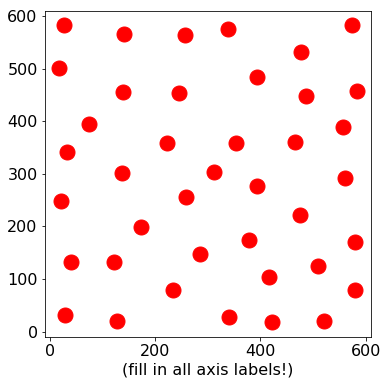

In [73]:
fig, ax = plt.subplots()
ax.plot(traj.xyz[10,:,0]*10,traj.xyz[10,:,1]*10, 'ro', ms=15)
ax.set_aspect('equal')
ax.set_xlabel(r'(fill in all axis labels!)')
ax.set_ylim(-10,610)
ax.set_xlim(-10,610)
plt.show()

We can also visualize trajectories using animated plots

In [74]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_ylim(-10,610)
ax.set_xlim(-10,610)

line, = ax.plot([], [], color='r', marker='o', lw=0, ms=15)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = traj.xyz[i,:,0]*10
    y = traj.xyz[i,:,1]*10
    line.set_data(x, y)
    return (line,)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=range(0,traj.n_frames,20), interval=200, blit=True)

display_animation(anim)

### Calculate histogram for uniform distribution (Hard Walls)

We now generate the distribution of particle distances for the case where these are completely uncorrelated, i.e. for an ideal 2D gas confined on a square with hard boundaries. This is done by randomly placing a large number of particles (the larger the number, the higher the accuracy) and build a histogram of distances.

In [75]:
from scipy.spatial import distance
ux = np.random.randint(0, L+1, 5000)
uy = np.random.randint(0, L+1, 5000)
upos = np.array([ux, uy]).T
hist = np.histogram(distance.pdist(upos), bins=150, normed=True)
ur = hist[1][1:]# / diameter
uP = hist[0]

### Calculate interparticle distances from the MC trajectory of the system without PBC

Here we are loading a trajectory for a system of *N* particles confined on a square by hard walls.<br>
Interparticle distances for all frames are calculated using the trajectory analysis `MDTraj` function [`compute_distances`](http://mdtraj.org/1.9.0/api/generated/mdtraj.compute_distances.html#mdtraj.compute_distances).

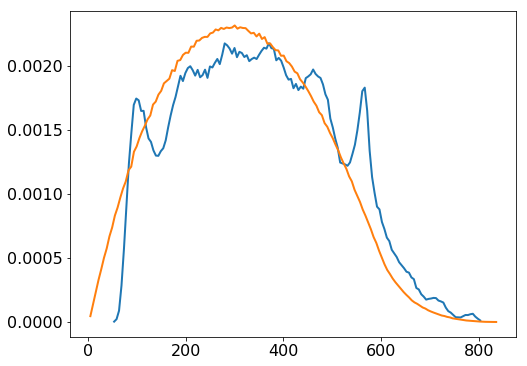

In [104]:
traj = md.load_xtc(trajname+'_nopbc.xtc',top=confname+'_nopbc.gro')
pairs = traj.top.select_pairs('name MP','name MP')
d = md.compute_distances(traj, atom_pairs=pairs, periodic=False, opt=True)*10
hist = np.histogram(d, bins=150, normed=True)
r = hist[1][1:]# / diameter
P = hist[0]*len(pairs)/(.5*N**2)
plt.plot(r, P,lw=2)
plt.plot(ur, uP,lw=2)
plt.show()

### Calculate histogram for uniform distribution (PBC with minimum image convention)

We now generate the distribution of particle distances for the case where these are uncorrelated, i.e. for an ideal 2D gas with PBC using the minimum image convention. This is done by (i) generating pairs of random numbers (x- and y-coordinates), (ii) calculating the distances between the points, (iii) building a histogram of distances.

In the following cell we present a slow implementation, analogous to the one previously used for the system without PBC.

In [77]:
%%time
ux = np.random.randint(0, L+1, 1000)
uy = np.random.randint(0, L+1, 1000)
upos = np.array([ux, uy]).T
def minimum_image(u,v): # calculate distance according to minimum image convention
    dvec = np.absolute(u-v)
    d2 = 0
    for i in dvec:
        if (i>L/2):
            d2 += (i-L)**2
        else:
            d2 += i**2
    return np.sqrt(d2)
hist = np.histogram(distance.pdist(upos,lambda u, v: minimum_image(u,v)), bins=150, normed=True)
ur_pbc = hist[1][1:]# / diameter
uP_pbc = hist[0]

CPU times: user 5.98 s, sys: 42.9 ms, total: 6.03 s
Wall time: 6.17 s


Here is a more efficient implementation.

In [79]:
%%time
ux = np.random.randint(0, L+1, 5000)
uy = np.random.randint(0, L+1, 5000)
upos = np.array([ux, uy]).T
def distPBC(d1,d2,half_len): # calculate distance according to minimum image convention
    half_len = int(half_len)
    delta = np.abs(d1-d2[:,np.newaxis])
    delta[delta>half_len] -= half_len*2
    return np.linalg.norm(delta,axis=2)
hist = np.histogram(distPBC(upos,upos,L/2.)[np.triu_indices(ux.size,k=1)], bins=150, normed=True)
ur_pbc = hist[1][1:]# / diameter
uP_pbc = hist[0]

CPU times: user 2.94 s, sys: 1.63 s, total: 4.57 s
Wall time: 5.19 s


### Calculate interparticle distances from the MC trajectory of the system with PBC

Here we are loading a trajectory for a system of *N* particles simulated with PBC.<br>
Interparticle distances for all frames are calculated using the trajectory analysis `MDTraj` function [`compute_distances`](http://mdtraj.org/1.9.0/api/generated/mdtraj.compute_distances.html#mdtraj.compute_distances).

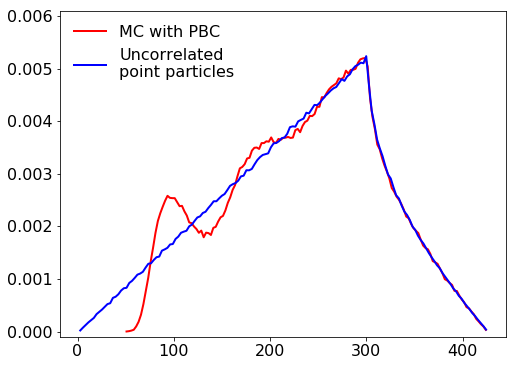

In [101]:
traj = md.load_xtc(trajname+'_pbc.xtc',top=confname+'_pbc.gro')
pairs = traj.top.select_pairs('name MP','name MP')
d = md.compute_distances(traj, atom_pairs=pairs, periodic=True, opt=True)*10
hist = np.histogram(d, bins=150, normed=True)
r_pbc = hist[1][1:]# / diameter
P_pbc = hist[0]*len(pairs)/(.5*N**2)
plt.plot(r_pbc, P_pbc,'r-',lw=2, label='MC with PBC')
plt.plot(ur_pbc, uP_pbc,'b-',lw=2, label='Uncorrelated\npoint particles')
plt.ylim(-.0001,0.0061)
plt.legend(frameon=False,loc='upper left')
plt.show()

### Calculate final distribution function, $g(r)$

In order to divide the simulated distribution with the one for uncorrelated particles, the data points in each set need to be aligned. This is achieved by splining the probability distributions against the same distance vector using the interpolation method by [Akima](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Akima1DInterpolator.html#scipy.interpolate.Akima1DInterpolator).

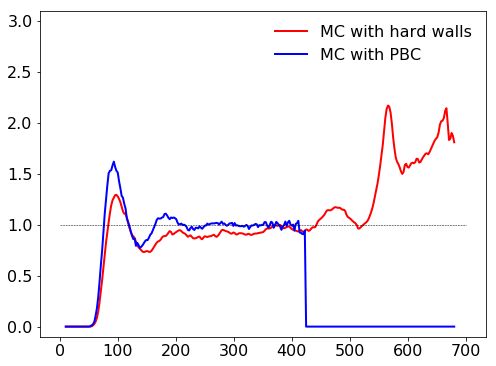

In [118]:
from scipy.interpolate import Akima1DInterpolator
rvals = np.linspace(10,L+80,300)
rdf = Akima1DInterpolator(r, P)(rvals) / Akima1DInterpolator(ur, uP)(rvals)
rdf_pbc = Akima1DInterpolator(r_pbc, P_pbc)(rvals) / Akima1DInterpolator(ur_pbc, uP_pbc)(rvals)
np.nan_to_num(rdf,copy=False); np.nan_to_num(rdf_pbc,copy=False) # replace NaN with zero
plt.plot(rvals, rdf, 'r-',lw=2,label='MC with hard walls')
plt.plot(rvals, rdf_pbc, 'b-',lw=2,label='MC with PBC')
plt.plot([0,700],[1,1],'k--',lw=0.5)
plt.ylim(-0.1,3.1)
plt.legend(frameon=False)
plt.show()

### Calculate average energy 

Integrate the pair potential over the volume around a test particle weighting by the radial distribution function:

In [125]:
area=L*L
u_rep = epsilon*(sigma/rvals)**12
u_dd = C/(rvals**3)
print( N**2/area*np.pi * np.trapz( rvals*rdf * (u_rep+u_dd), rvals ) ) 

262.154364747


In [126]:
!head energy_40_nopbc.dat

#total nonbonded confine
10 262.466 262.466 0
20 197.488 197.488 0
30 193.084 193.084 0
40 188.44 188.44 0
50 185.692 185.692 0
60 183.067 183.067 0
70 176.271 176.271 0
80 176.299 176.299 0
90 180.176 180.176 0


In [127]:
energy_nonbonded = np.loadtxt(energyname+'_pbc.dat',usecols=(1))
energy_nonbonded.mean()

283.06894

### Exercises, Part II

0. For all figures, label axes specifying the units.
0. Explore the particle displacement parameter. How does this influence the mean square displacement and move acceptance? Does it influence the final result?
0. How does temperature enter the simulation?
0. Run simulation with and without PBC for systems of various number of particles.
0. Observe the  distance distribution, $P(r)$, for magnetic particles in a 2D system of side length 600 pixels, with PBC. Why does $P(r)$ increase linearly with $r$ for $r<300$ pixels? What $r$-dependence would you expect for a 3D system? (Hint: Read paragraph 17-1 in Hill's book - especially page 301. Please mention the difference between the infinitesimal area and volume elements in 2D and 3D, respectively.)
0. Observe the radial distribution functions, RDF or $g(r)$, obtained from the 2D particle simulator and from MC simulations of magnetic particles, with and without PBC. Comment on the differences between the three RDFs, and explain the deviation from unity at large separations observed in the simulation result (with and without PBC) and for the 2D particle simulator.  (Hint: In the 2D particle simulator the walls are magnetic bars, not just hard walls.)
0. Simulate $g(r)$ with PBC for non-interacting particles (N.B. both dipole-dipole and size-exclusion interactions should be vanishing). Although in theory it should, the curve may not be unity for all distances. Why?
0. List the differences between the particle simulator and the MC system. (Hint: discuss at least boundaries, interactions).
0. Complete the script in the last cell of the notebook to calculate the average energy of the system with the following integral:

\begin{equation}
\bar{U} = \frac{N^2}{2A} \int_0^\infty \mathrm{d}r 2\pi r \left ( u_{rep}(r) + u_{d-d}(r) \right ) g(r)
\end{equation}
0. Compare the energy calculated from the $g(r)$ with the average of the energies calculated every 10 frames during the simulation and saved in the `energy_N_pbc.dat` or `energy_N_nopbc.dat` files.